In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/wikipedia-structured-contents/enwiki_namespace_0/enwiki_namespace_0_31.jsonl
/kaggle/input/wikipedia-structured-contents/enwiki_namespace_0/enwiki_namespace_0_26.jsonl
/kaggle/input/wikipedia-structured-contents/enwiki_namespace_0/enwiki_namespace_0_35.jsonl
/kaggle/input/wikipedia-structured-contents/enwiki_namespace_0/enwiki_namespace_0_14.jsonl
/kaggle/input/wikipedia-structured-contents/enwiki_namespace_0/enwiki_namespace_0_2.jsonl
/kaggle/input/wikipedia-structured-contents/enwiki_namespace_0/enwiki_namespace_0_21.jsonl
/kaggle/input/wikipedia-structured-contents/enwiki_namespace_0/enwiki_namespace_0_34.jsonl
/kaggle/input/wikipedia-structured-contents/enwiki_namespace_0/enwiki_namespace_0_10.jsonl
/kaggle/input/wikipedia-structured-contents/enwiki_namespace_0/enwiki_namespace_0_22.jsonl
/kaggle/input/wikipedia-structured-contents/enwiki_namespace_0/enwiki_namespace_0_20.jsonl
/kaggle/input/wikipedia-structured-contents/enwiki_namespace_0/enwiki_namespace_0_32.jsonl


# IMPORTING LIBRARIES

In [3]:
%matplotlib inline
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import os
from tqdm import tqdm
from datetime import datetime
import re
from wordcloud import WordCloud
import networkx as nx
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100
sns.set(style="whitegrid")

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')


In [4]:
def read_jsonl(file_path, max_records=None):
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(tqdm(f)):
            if max_records and i >= max_records:
                break
            data.append(json.loads(line))
    return data


In [5]:
import kagglehub
file_path = kagglehub.dataset_download("wikimedia-foundation/wikipedia-structured-contents",path="enwiki_namespace_0/enwiki_namespace_0_0.jsonl")
data = read_jsonl(file_path)
print(f"Successfully loaded {len(data)} records")


309509it [01:09, 4444.03it/s]

Successfully loaded 309509 records


In [6]:
df = pd.DataFrame(data)
print(f"Dataset shape: {df.shape}")
print("\nColumns in the dataset:")
for col in df.columns:
    print(f"- {col}")


Dataset shape: (309509, 17)

Columns in the dataset:
- name
- identifier
- version
- event
- url
- date_created
- date_modified
- is_part_of
- in_language
- license
- description
- sections
- abstract
- main_entity
- additional_entities
- infoboxes
- image


In [7]:
print(f"sample data {display(df.head())}")

,name,identifier,version,event,url,date_created,date_modified,is_part_of,in_language,license,description,sections,abstract,main_entity,additional_entities,infoboxes,image
0,Not Again SU,76716259,"{'identifier': 1220413474, 'comment': 'Added #...",{'identifier': 'fa3cae5b-8707-4f55-9fab-5baa4c...,https://en.wikipedia.org/wiki/Not_Again_SU,2024-04-23T16:50:32Z,2024-04-23T16:53:55Z,"{'identifier': 'enwiki', 'url': 'https://en.wi...",{'identifier': 'en'},[{'name': 'Creative Commons Attribution-ShareA...,"Student organization in Syracuse, New York","[{'type': 'section', 'name': 'Abstract'}, {'ty...",NaN,NaN,NaN,NaN,NaN
1,Mike Ross (Suits),76727681,"{'identifier': 1220574416, 'comment': 'Request...",{'identifier': '22366970-ddf7-43dc-8cec-941de1...,https://en.wikipedia.org/wiki/Mike_Ross_(Suits),2024-04-24T17:12:05Z,2024-04-24T17:14:10Z,"{'identifier': 'enwiki', 'url': 'https://en.wi...",{'identifier': 'en'},[{'name': 'Creative Commons Attribution-ShareA...,An American Legal drama series from 2011-2019,"[{'type': 'section', 'name': 'Abstract', 'has_...",REDIRECT List of Suits characters#Mike Ross,"{'identifier': 'Q125388612', 'url': 'https://w...","[{'identifier': 'Q125388612', 'url': 'https://...",NaN,NaN
2,Second Polish republic,76744378,"{'identifier': 1220875620, 'comment': '[[WP:AE...",{'identifier': '552624d6-5c55-45ef-a8e3-945335...,https://en.wikipedia.org/wiki/Second_Polish_re...,2024-04-26T13:30:10Z,2024-04-26T13:30:10Z,"{'identifier': 'enwiki', 'url': 'https://en.wi...",{'identifier': 'en'},[{'name': 'Creative Commons Attribution-ShareA...,Country in Central and Eastern Europe (1918–1939),"[{'type': 'section', 'name': 'Abstract', 'has_...",REDIRECT #Second Polish Republic,NaN,NaN,NaN,NaN
3,Left-to-right script,76735997,"{'identifier': 1220716997, 'comment': 'create ...",{'identifier': 'aae6c4ee-bf95-4dc0-942d-5eea53...,https://en.wikipedia.org/wiki/Left-to-right_sc...,2024-04-25T13:58:39Z,2024-04-25T13:58:39Z,"{'identifier': 'enwiki', 'url': 'https://en.wi...",{'identifier': 'en'},[{'name': 'Creative Commons Attribution-ShareA...,Convention of symbols representing language,"[{'type': 'section', 'name': 'Abstract', 'has_...",REDIRECT Writing system#Directionality,NaN,NaN,NaN,NaN
4,1442 in France,58128987,"{'identifier': 1145356533, 'comment': 'Alter: ...",{'identifier': 'c4526432-0a4a-42ed-8ef7-54827c...,https://en.wikipedia.org/wiki/1442_in_France,NaN,2023-03-18T18:38:51Z,"{'identifier': 'enwiki', 'url': 'https://en.wi...",{'identifier': 'en'},[{'name': 'Creative Commons Attribution-ShareA...,List of events in the year 1442,"[{'type': 'section', 'name': 'Abstract', 'has_...",Events from the year 1442 in France,"{'identifier': 'Q56292328', 'url': 'https://ww...","[{'identifier': 'Q56292328', 'url': 'https://w...","[{'type': 'infobox', 'name': 'Year in France h...",NaN


sample data None


# Feature Engineering and EDA

Missing Data Analysis:
                      Count  Percentage
date_created         309209    0.999031
image                218902    0.707256
infoboxes             97441    0.314824
description           56858    0.183704
abstract                505    0.001632
main_entity             381    0.001231
additional_entities     376    0.001215
sections                 62    0.000200
license                   0    0.000000
name                      0    0.000000
identifier                0    0.000000
is_part_of                0    0.000000
date_modified             0    0.000000
url                       0    0.000000
event                     0    0.000000
version                   0    0.000000
in_language               0    0.000000


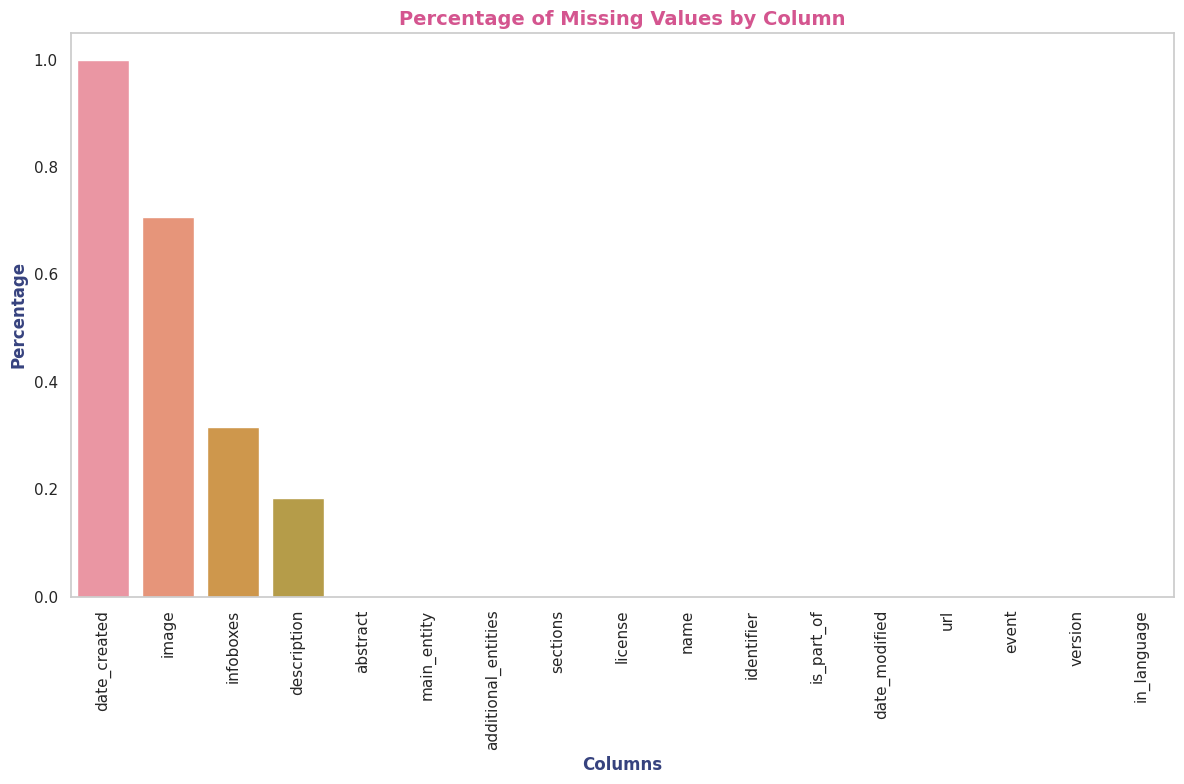

In [8]:
# Missing Value Analysis
def missing_value_analysis(df):
    """
        Analyzing and visualizing missing values in a Pandas DataFrame.
    
        Args:
            df (pd.DataFrame): The DataFrame to analyze.
    """
    missing_counts = df.isnull().sum().sort_values(ascending=False)
    missing_percentage = (df.isnull().sum() / len(df)).sort_values(ascending=False)
    missing_data = pd.concat([missing_counts, missing_percentage], axis=1, keys=['Count', 'Percentage'])
    print("Missing Data Analysis:")
    print(missing_data)

    plt.figure(figsize=(12, 8))
    sns.barplot(x=missing_data.index, y=missing_data['Percentage'])
    plt.xticks(rotation=90)
    plt.title('Percentage of Missing Values by Column', fontsize=14, fontweight='bold', color='#d4558f')
    plt.xlabel('Columns', fontsize=12, fontweight='bold', color='#36427e')
    plt.ylabel('Percentage', fontsize=12, fontweight='bold', color='#36427e')
    plt.tight_layout()
    plt.gca().set_facecolor('#ffffff')
    plt.grid(False)
    plt.show()

missing_value_analysis(df)


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


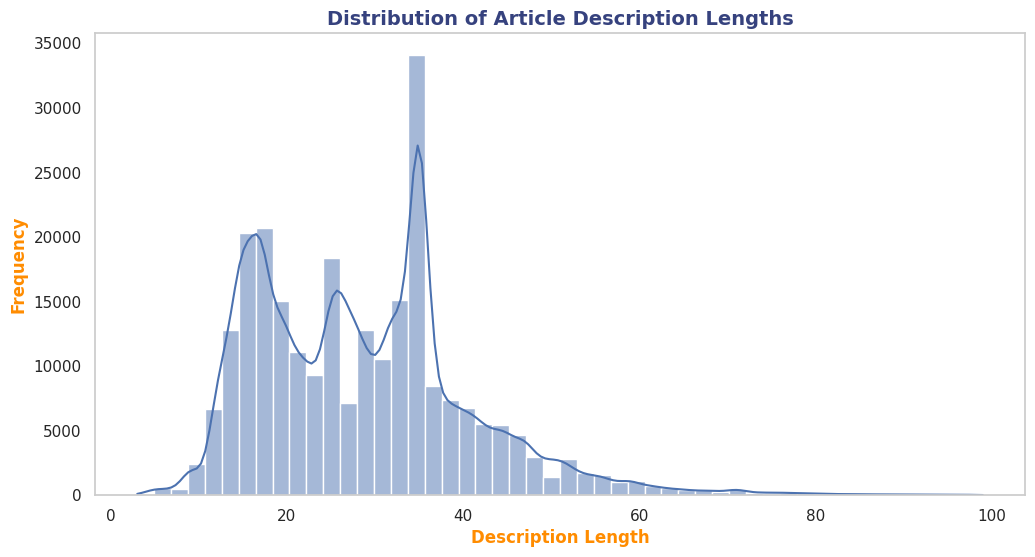

In [9]:
# Distribution of Article Lengths (Description)
df['description_length'] = df['description'].str.len()
df_no_na = df.dropna(subset=['description_length'])
plt.figure(figsize=(12, 6))
sns.histplot(df_no_na['description_length'], bins=50, kde=True)
plt.title('Distribution of Article Description Lengths', fontsize=14, fontweight='bold', color='#36427e')
plt.xlabel('Description Length', fontsize=12, fontweight='bold', color='darkorange')
plt.ylabel('Frequency', fontsize=12, fontweight='bold', color='darkorange')
plt.gca().set_facecolor('#ffffff')
plt.grid(False)
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


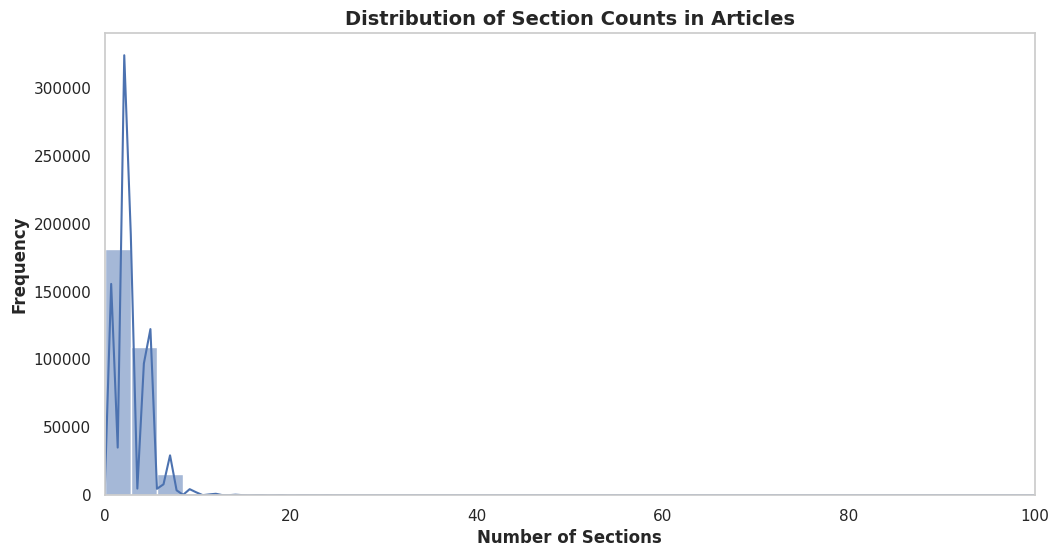

In [11]:
# Distribution of Section Counts

# Function to count sections, handling missing or non-list values
def count_sections(sections):
    if isinstance(sections, list):
        return len(sections)
    else:
        return 0  # Return 0 for missing or non-list values

# Apply the function to the 'sections' column to create 'section_count'
df['section_count'] = df['sections'].apply(count_sections)

# Plotting the distribution
plt.figure(figsize=(12, 6))
sns.histplot(df['section_count'], bins=50, kde=True)
plt.title('Distribution of Section Counts in Articles', fontsize=14, fontweight='bold')
plt.xlabel('Number of Sections', fontsize=12, fontweight='bold')
plt.ylabel('Frequency', fontsize=12, fontweight='bold')
plt.xlim(0, 100)  # Limit x-axis for better readability
plt.gca()
plt.grid(False)
plt.show()



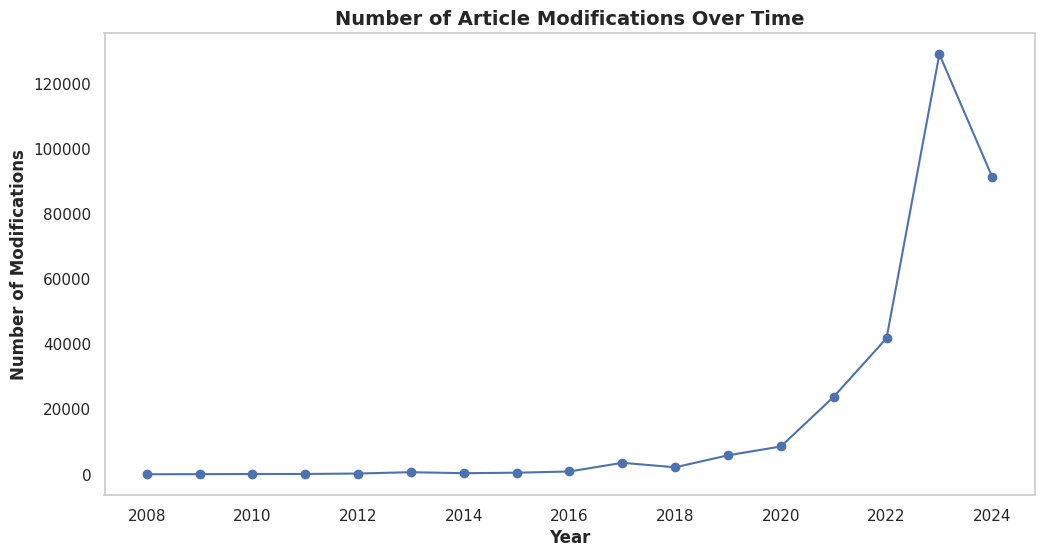

In [12]:
# Article Modification Over Time
df['date_modified'] = pd.to_datetime(df['date_modified'], errors='coerce')
df = df.dropna(subset=['date_modified'])
df['modification_year'] = df['date_modified'].dt.year
modifications_per_year = df['modification_year'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
modifications_per_year.plot(kind='line', marker='o')
plt.title('Number of Article Modifications Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Year', fontsize=12, fontweight='bold')
plt.ylabel('Number of Modifications', fontsize=12, fontweight='bold')
plt.gca()
plt.grid(False)
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


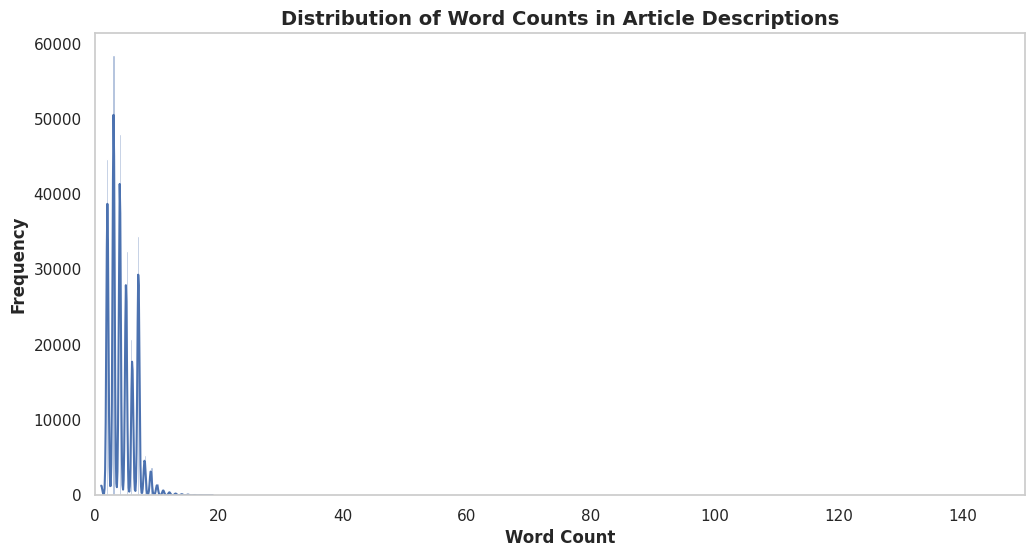

In [13]:
# Distribution of Description Word Counts
df['description_word_count'] = df['description'].str.split().str.len()
df_no_na = df.dropna(subset=['description_word_count'])

plt.figure(figsize=(12, 6))
sns.histplot(df_no_na['description_word_count'], bins=50, kde=True)
plt.title('Distribution of Word Counts in Article Descriptions', fontsize=14, fontweight='bold')
plt.xlabel('Word Count', fontsize=12, fontweight='bold')
plt.ylabel('Frequency', fontsize=12, fontweight='bold')
plt.xlim(0, 150)  # Limit x-axis for better readability
plt.gca()
plt.grid(False)
plt.show()


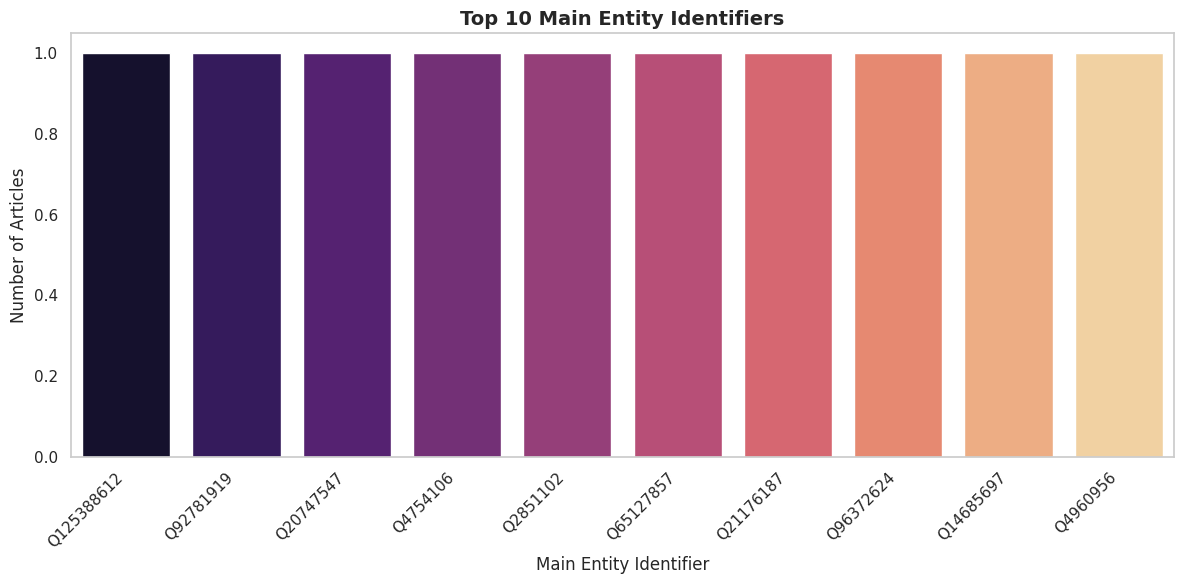

In [14]:
# Analysis of main_entity identifiers
# Extract main entity identifiers
df['main_entity_id'] = df['main_entity'].apply(lambda x: x['identifier'] if isinstance(x, dict) else None)

# Count occurrences of each identifier
entity_counts = df['main_entity_id'].value_counts().nlargest(10)

# Create bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=entity_counts.index, y=entity_counts.values, palette="magma")
plt.title('Top 10 Main Entity Identifiers', fontsize=14, fontweight='bold')
plt.xlabel('Main Entity Identifier')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.gca()
plt.grid(False)
plt.show()


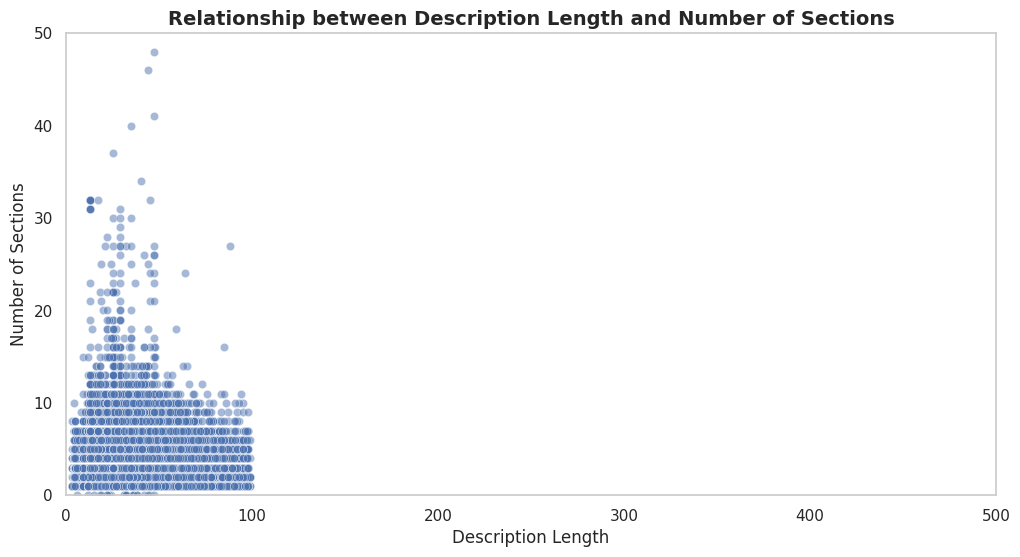

In [15]:
# Relationship between description length and number of sections
# Ensure 'description_length' and 'section_count' exist
if 'description_length' not in df.columns:
    df['description_length'] = df['description'].str.len()
if 'section_count' not in df.columns:
    def count_sections(sections):
        if isinstance(sections, list):
            return len(sections)
        else:
            return 0
    df['section_count'] = df['sections'].apply(count_sections)

# Remove rows with missing values in either column
df_no_na = df.dropna(subset=['description_length', 'section_count'])

# Create a scatter plot
plt.figure(figsize=(12, 6))
sns.scatterplot(x=df_no_na['description_length'], y=df_no_na['section_count'], alpha=0.5)
plt.title('Relationship between Description Length and Number of Sections', fontsize=14, fontweight='bold')
plt.xlabel('Description Length')
plt.ylabel('Number of Sections')
plt.xlim(0, 500)  # Limit x-axis for better readability
plt.ylim(0, 50)   # Limit y-axis for better readability
plt.gca()
plt.grid(False)
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


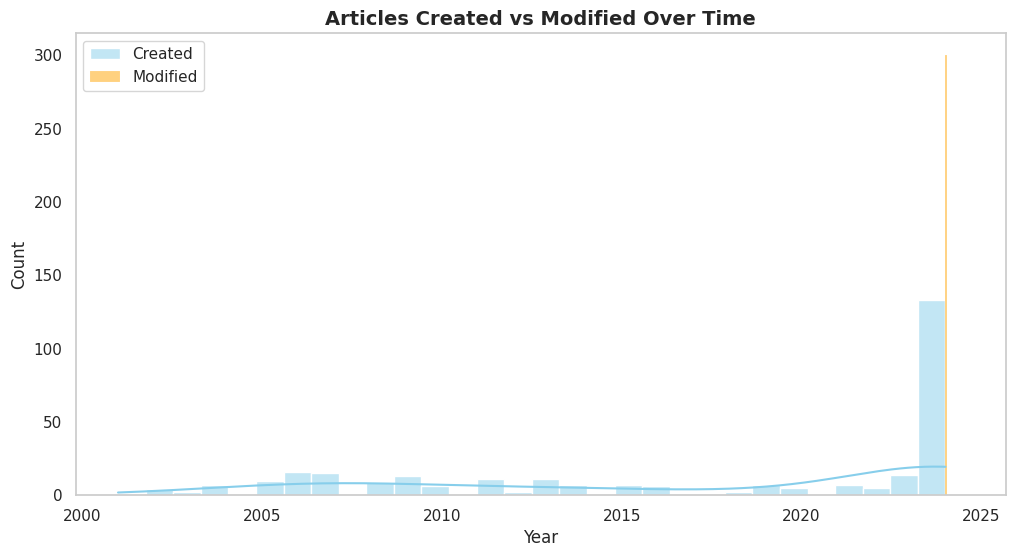

In [16]:
# Convert date columns
df['date_created'] = pd.to_datetime(df['date_created'], errors='coerce')
df['date_modified'] = pd.to_datetime(df['date_modified'], errors='coerce')

# Plot creation and modification trends
df_dates = df[['date_created', 'date_modified']].dropna()
df_dates['created_year'] = df_dates['date_created'].dt.year
df_dates['modified_year'] = df_dates['date_modified'].dt.year

# Plotting
plt.figure(figsize=(12,6))
sns.histplot(df_dates['created_year'], bins=30, color='skyblue', label='Created', kde=True)
sns.histplot(df_dates['modified_year'], bins=30, color='orange', label='Modified', kde=True)
plt.title('Articles Created vs Modified Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Count')
plt.gca()
plt.grid(False)
plt.legend()
plt.show()


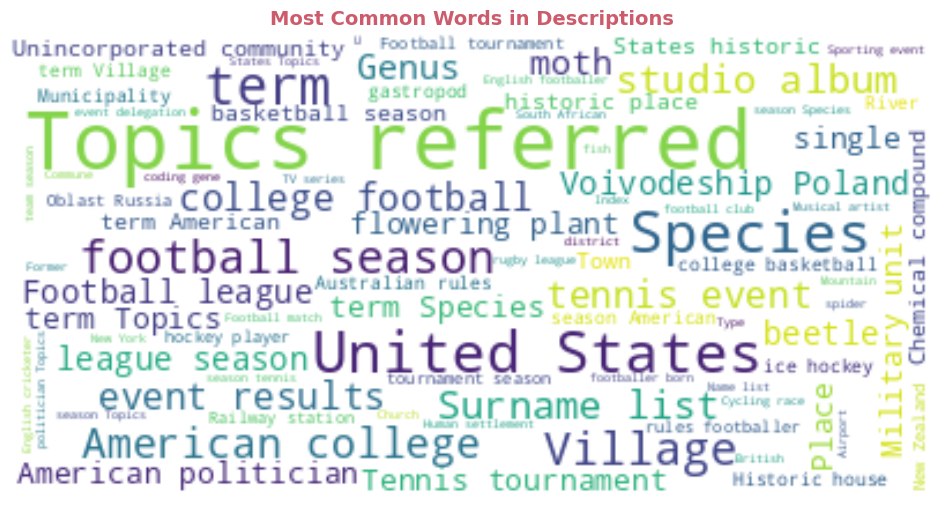

In [17]:
text = ' '.join(df['description'].dropna())
stop_words = set(stopwords.words('english'))
wordcloud = WordCloud(stopwords=stop_words, background_color='white', max_words=200).generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Words in Descriptions", fontsize=14, fontweight='bold', color='#cc5c6c')
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


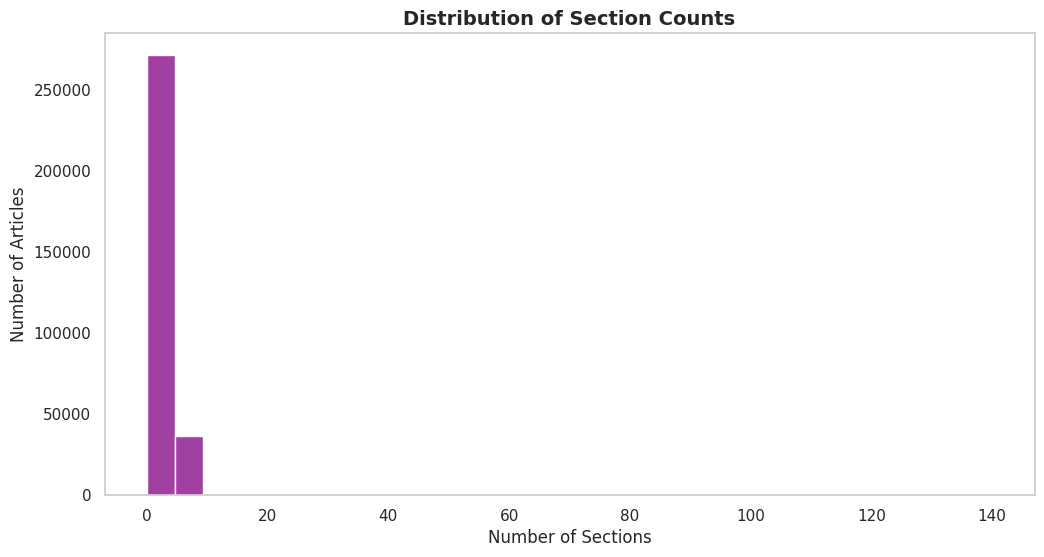

In [18]:
df['num_sections'] = df['sections'].apply(lambda x: len(x) if isinstance(x, list) else 0)

sns.histplot(df['num_sections'], bins=30, color='purple')
plt.title('Distribution of Section Counts', fontsize=14, fontweight='bold')
plt.xlabel('Number of Sections')
plt.ylabel('Number of Articles')
plt.gca()
plt.grid(False)
plt.show()


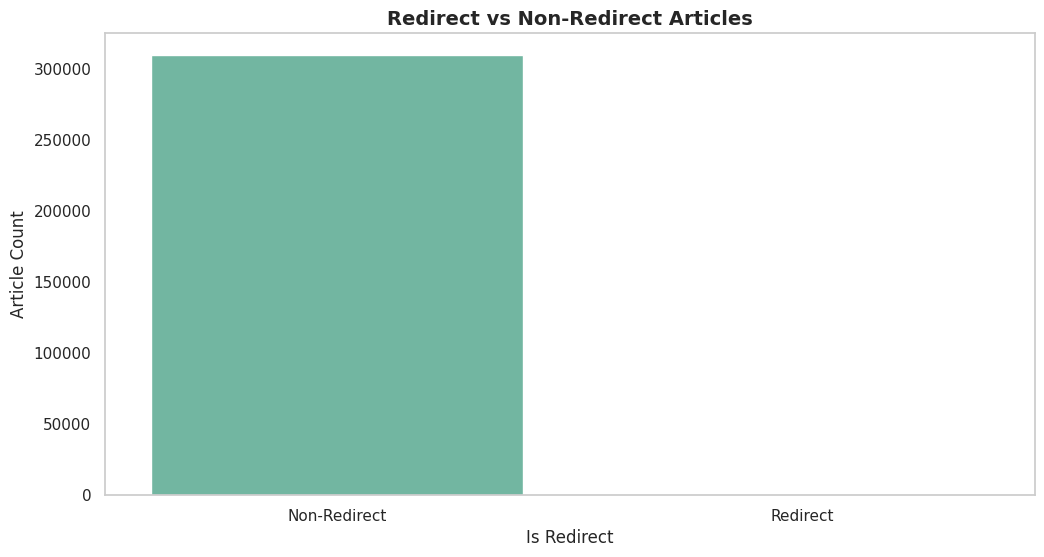

In [19]:
df['is_redirect'] = df['abstract'].astype(str).str.contains("REDIRECT", case=False)

sns.countplot(x='is_redirect', data=df, palette='Set2')
plt.title('Redirect vs Non-Redirect Articles', fontsize=14, fontweight='bold')
plt.xlabel('Is Redirect')
plt.ylabel('Article Count')
plt.xticks([0, 1], ['Non-Redirect', 'Redirect'])
plt.gca()
plt.grid(False)
plt.show()


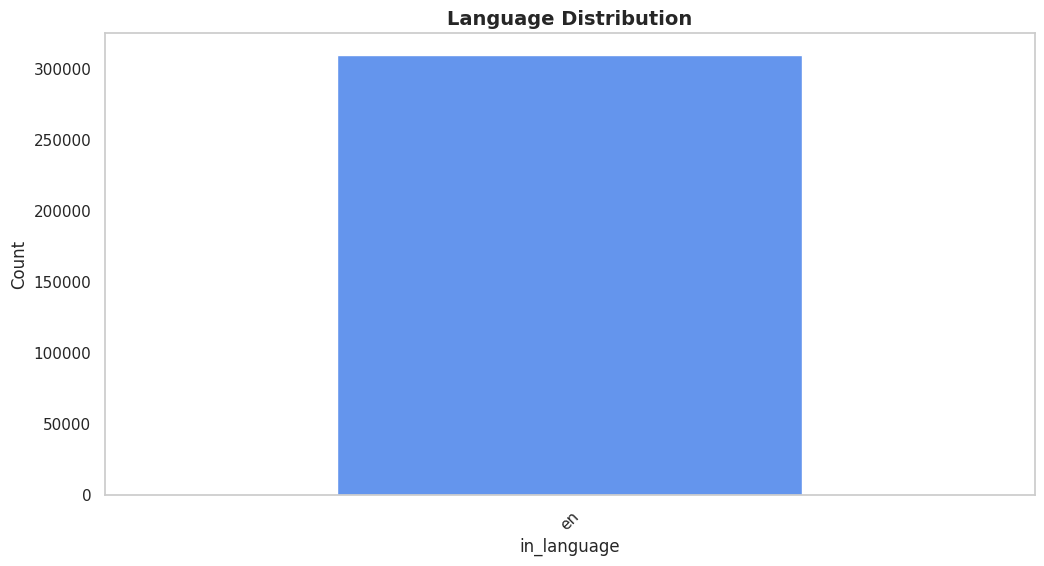

In [20]:
lang_counts = df['in_language'].dropna().apply(lambda x: x.get('identifier') if isinstance(x, dict) else x).value_counts()

lang_counts.plot(kind='bar', color='cornflowerblue')
plt.title('Language Distribution', fontsize=14, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.gca()
plt.grid(False)
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


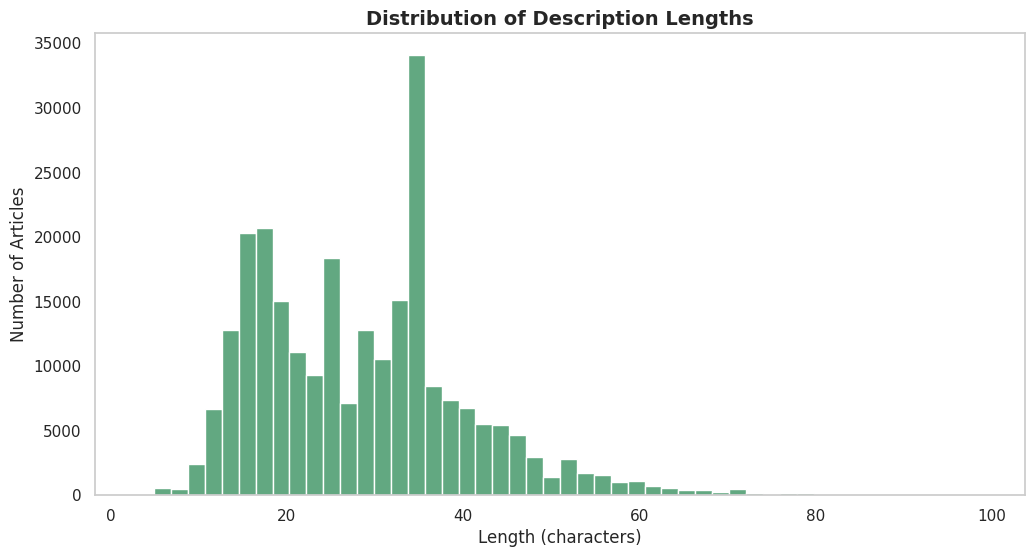

In [21]:
df['desc_length'] = df['description'].dropna().apply(lambda x: len(x))
sns.histplot(df['desc_length'], bins=50, color='seagreen')
plt.title("Distribution of Description Lengths", fontsize=14, fontweight='bold')
plt.xlabel("Length (characters)")
plt.ylabel("Number of Articles")
plt.gca()
plt.grid(False)
plt.show()


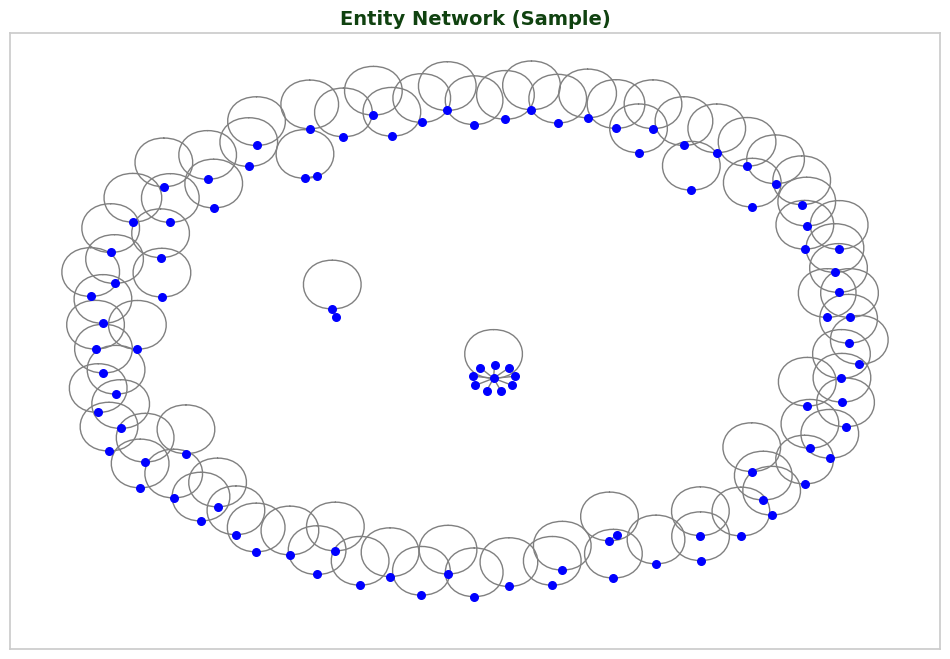

In [22]:
edges = []
for idx, row in df.dropna(subset=['main_entity', 'additional_entities']).iterrows():
    main = row['main_entity'].get('identifier') if isinstance(row['main_entity'], dict) else None
    others = [e.get('identifier') for e in row['additional_entities']] if isinstance(row['additional_entities'], list) else []
    for o in others:
        edges.append((main, o))

G = nx.Graph()
G.add_edges_from(edges[:100])  # for visualization, only 100 connections

plt.figure(figsize=(12, 8))
nx.draw_networkx(G, with_labels=False, node_size=30, edge_color='gray', node_color='blue')
plt.title("Entity Network (Sample)", fontsize=14, fontweight='bold', color='#104210')
plt.gca()
plt.grid(False)
plt.show()


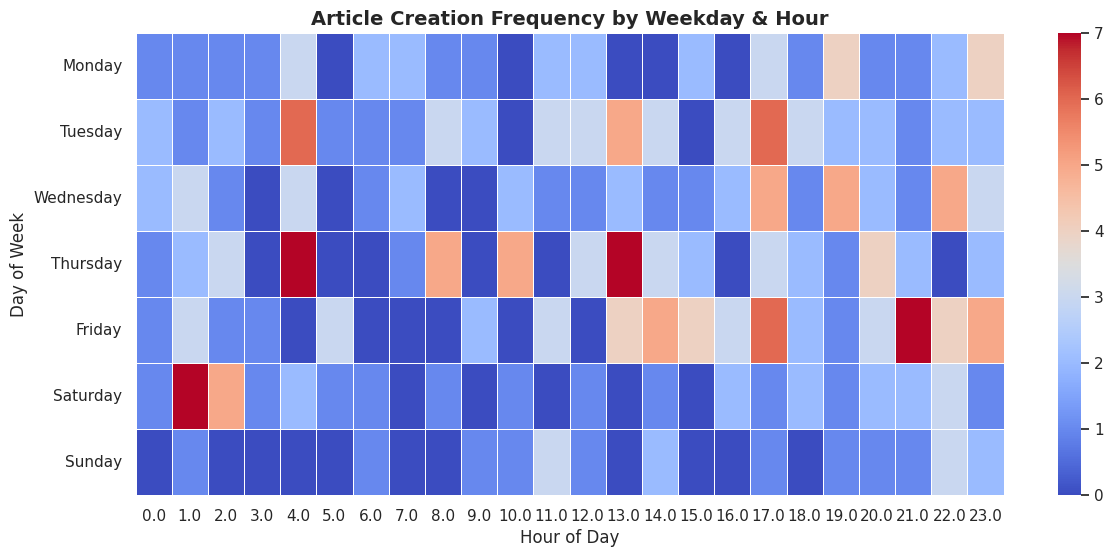

In [24]:
df['hour'] = df['date_created'].dt.hour
df['weekday'] = df['date_created'].dt.day_name()

heatmap_data = df.dropna(subset=['hour', 'weekday']).groupby(['weekday', 'hour']).size().unstack().fillna(0)
# Order weekdays
heatmap_data = heatmap_data.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_data, cmap="coolwarm", linewidths=.5)
plt.title('Article Creation Frequency by Weekday & Hour', fontsize=14, fontweight='bold')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.show()


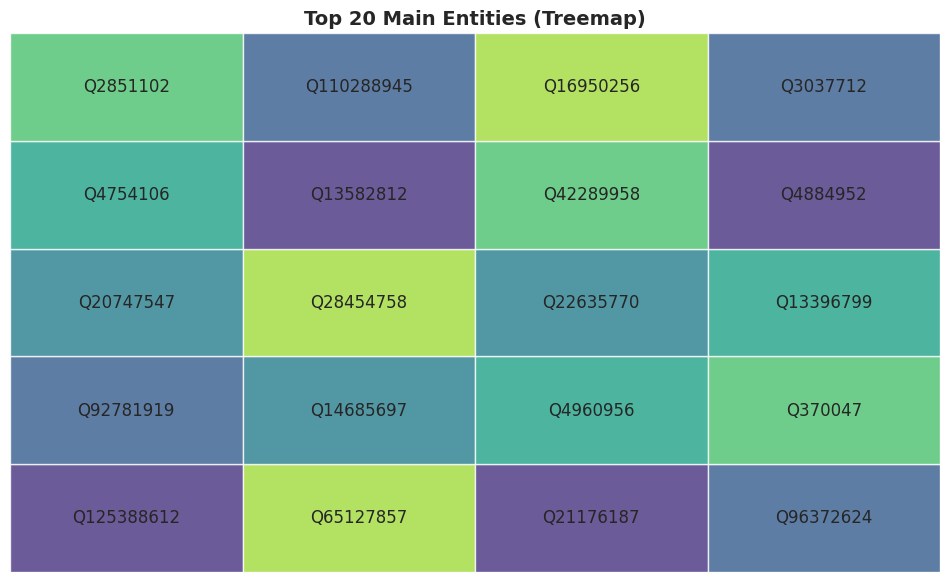

In [25]:
import squarify

main_entities = df['main_entity'].dropna().apply(lambda x: x['identifier'] if isinstance(x, dict) else None)
top_entities = main_entities.value_counts().head(20)

plt.figure(figsize=(12, 7))
squarify.plot(sizes=top_entities.values, label=top_entities.index, alpha=0.8, color=sns.color_palette('viridis'))
plt.title("Top 20 Main Entities (Treemap)", fontsize=14, fontweight='bold')
plt.axis('off')
plt.show()


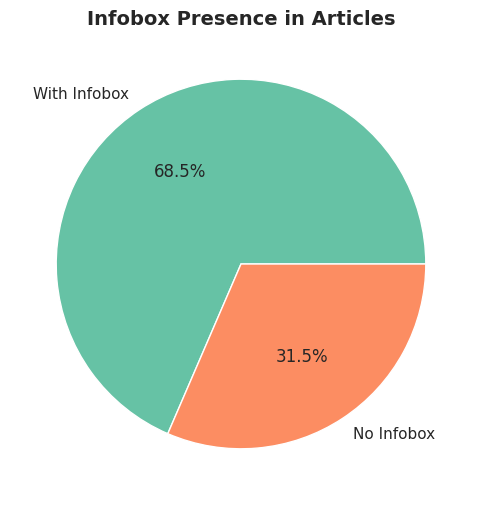

In [26]:
has_infobox = df['infoboxes'].notna().value_counts()
plt.figure()
has_infobox.plot(kind='pie', labels=['With Infobox', 'No Infobox'], autopct='%1.1f%%', colors=['#66c2a5','#fc8d62'])
plt.title("Infobox Presence in Articles", fontsize=14, fontweight='bold')
plt.ylabel('')
plt.show()


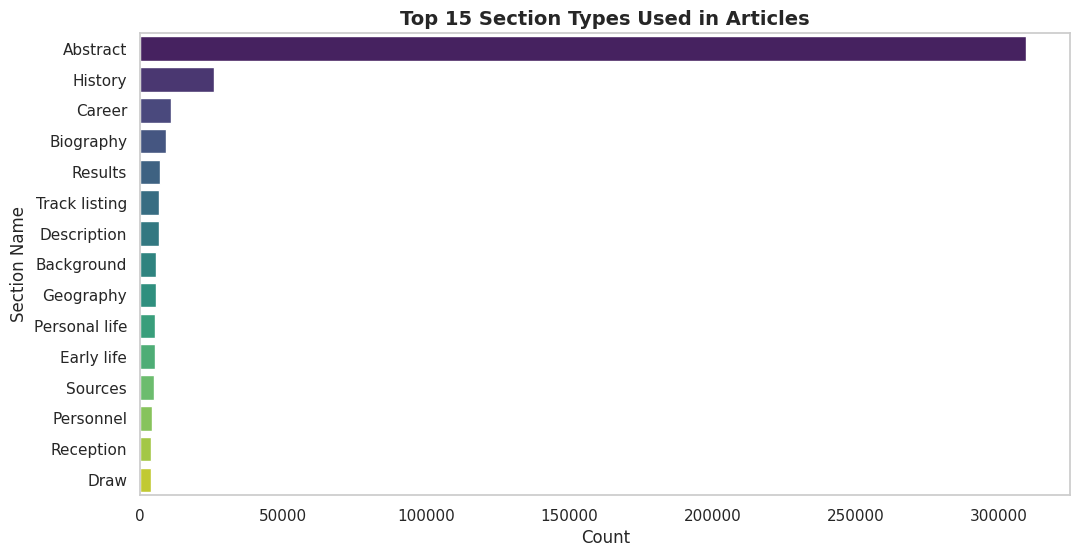

In [27]:
section_types = df['sections'].dropna().explode().apply(lambda x: x.get('name') if isinstance(x, dict) else None)
top_sections = section_types.value_counts().head(15)

sns.barplot(x=top_sections.values, y=top_sections.index, palette="viridis")
plt.title("Top 15 Section Types Used in Articles", fontsize=14, fontweight='bold')
plt.xlabel("Count")
plt.ylabel("Section Name")
plt.gca()
plt.grid(False)
plt.show()


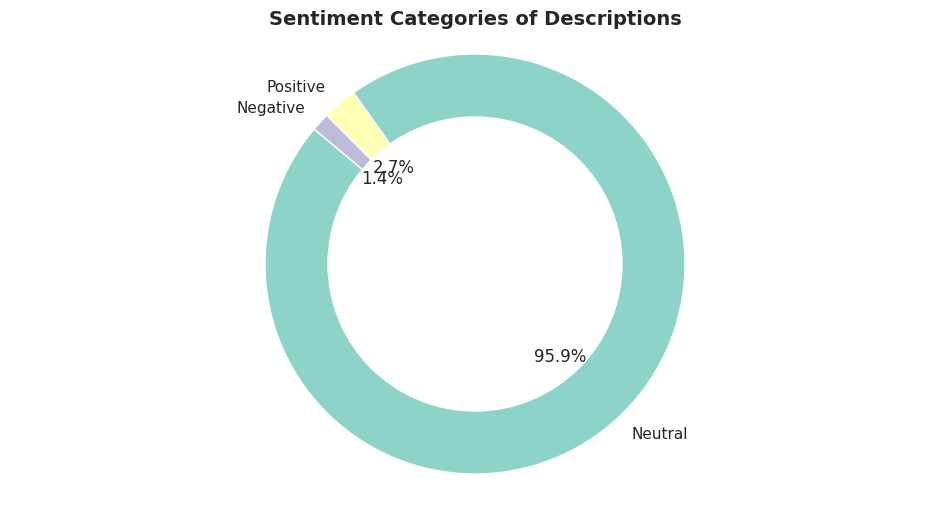

In [28]:
def sentiment_category(p):
    if p > 0.1:
        return 'Positive'
    elif p < -0.1:
        return 'Negative'
    else:
        return 'Neutral'

sent_cat = df['description'].dropna().apply(lambda x: sentiment_category(TextBlob(x).sentiment.polarity))
counts = sent_cat.value_counts()

# Donut chart
plt.figure()
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Set3'))
centre_circle = plt.Circle((0,0),0.70,fc='white')
plt.gca().add_artist(centre_circle)
plt.title('Sentiment Categories of Descriptions', fontsize=14, fontweight='bold')
plt.axis('equal')
plt.show()


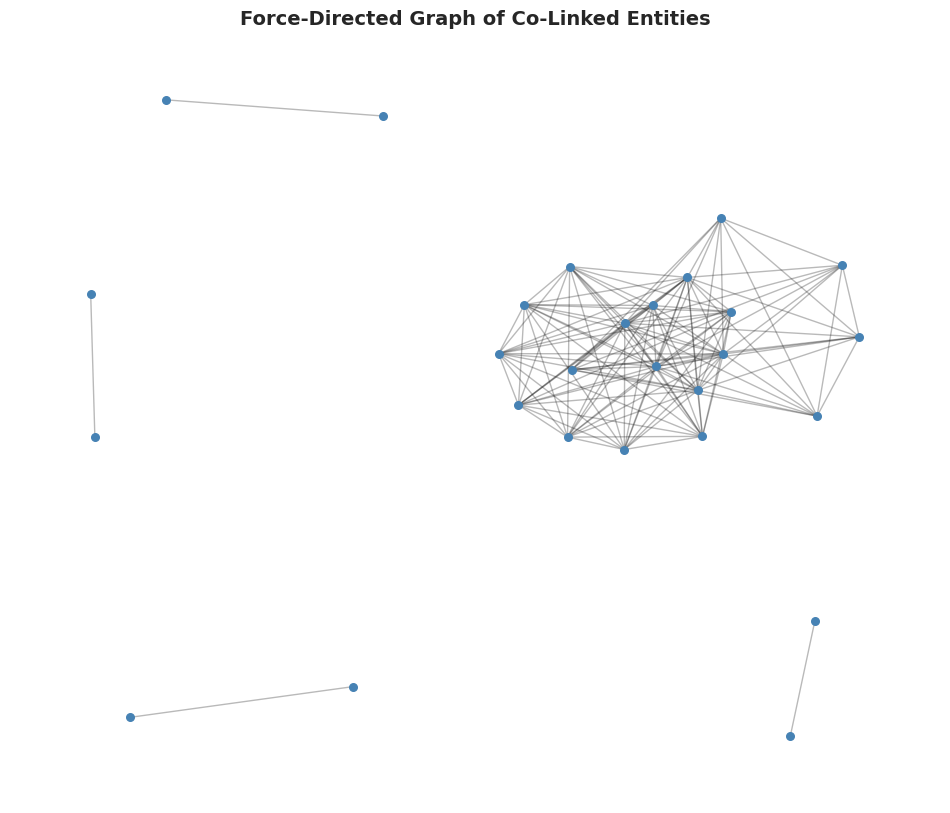

In [29]:
from itertools import combinations

G = nx.Graph()
for _, row in df.dropna(subset=['additional_entities']).head(200).iterrows():
    entities = [e['identifier'] for e in row['additional_entities'] if 'identifier' in e]
    for a, b in combinations(entities, 2):
        G.add_edge(a, b)

plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, k=0.5, iterations=20)
nx.draw_networkx_nodes(G, pos, node_size=30, node_color='steelblue')
nx.draw_networkx_edges(G, pos, alpha=0.3)
plt.title("Force-Directed Graph of Co-Linked Entities", fontsize=14, fontweight='bold')
plt.axis('off')
plt.show()


/tmp/ipykernel_117/1493744062.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['month_created'] = df['date_created'].dt.to_period('M')


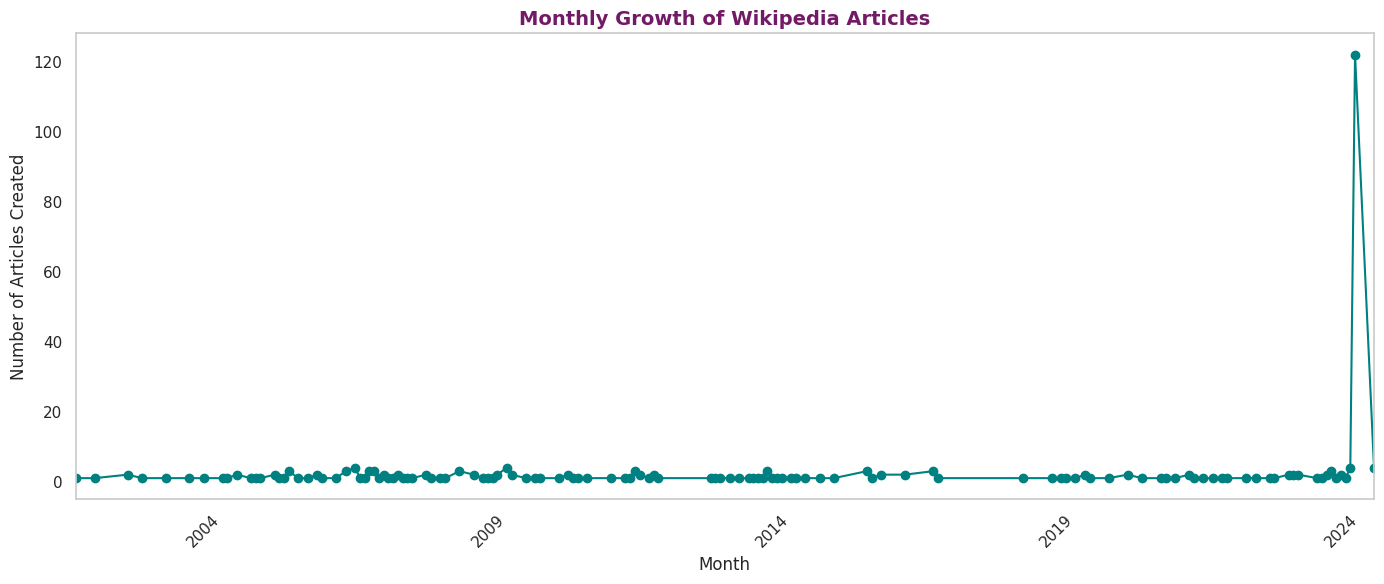

In [30]:
df['month_created'] = df['date_created'].dt.to_period('M')
monthly_growth = df.dropna(subset=['month_created']).groupby('month_created').size()

plt.figure(figsize=(14, 6))
monthly_growth.plot(kind='line', marker='o', color='teal')
plt.title('Monthly Growth of Wikipedia Articles', fontsize=14, fontweight='bold', color='#721a65')
plt.xlabel('Month')
plt.ylabel('Number of Articles Created')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.gca()
plt.grid(False)
plt.show()


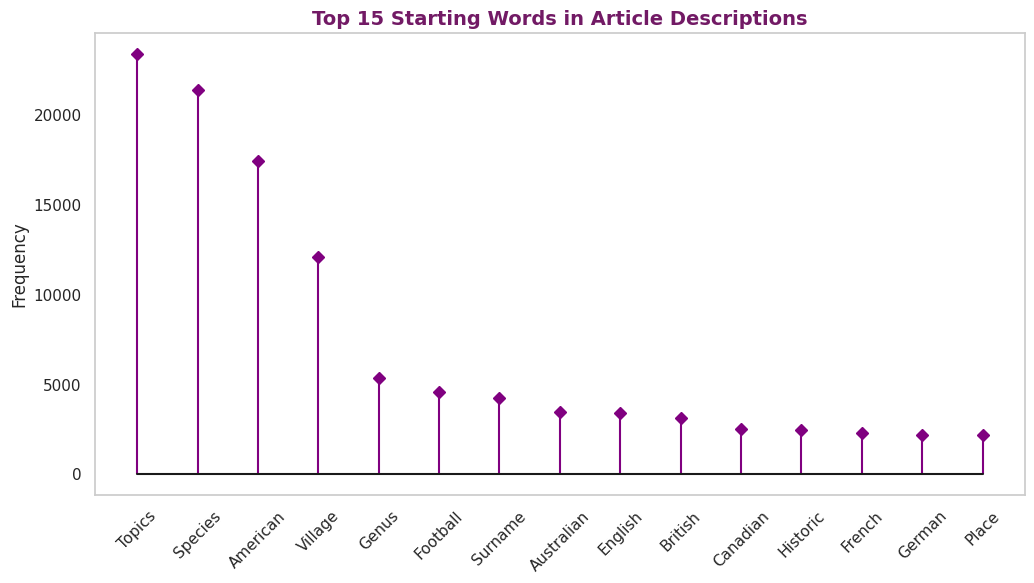

In [31]:
abstract_starts = df['description'].dropna().apply(lambda x: x.split()[0] if len(x.split()) > 0 else None)
top_starts = abstract_starts.value_counts().head(15)

plt.figure(figsize=(12, 6))
plt.stem(top_starts.index, top_starts.values, linefmt='purple', markerfmt='D', basefmt='k')
plt.title("Top 15 Starting Words in Article Descriptions", fontsize=14, fontweight='bold', color='#721a65')
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.gca()
plt.grid(False)
plt.show()


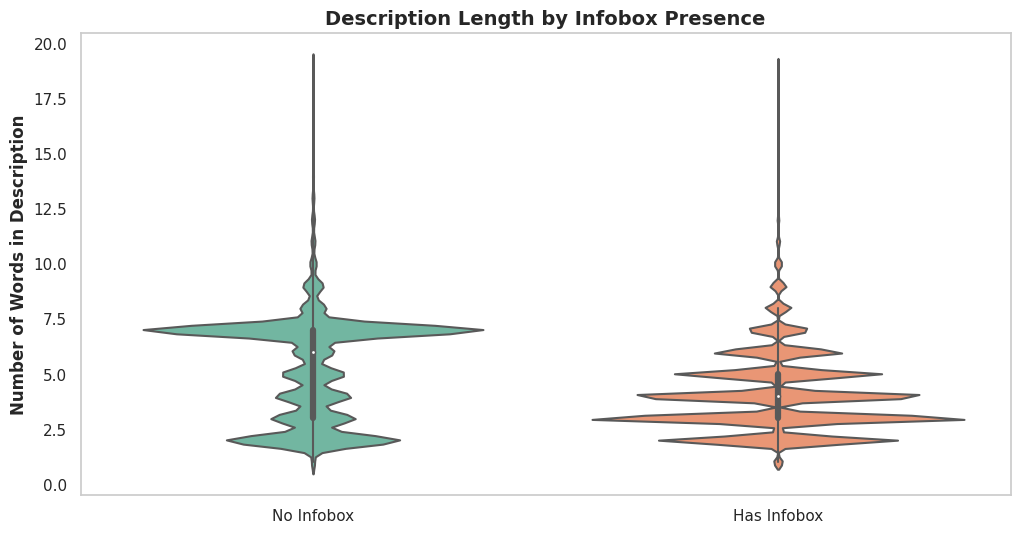

In [33]:
df['description_length'] = df['description'].dropna().apply(lambda x: len(x.split()))
df['has_infobox'] = df['infoboxes'].notna()

sns.violinplot(data=df.dropna(subset=['description_length']), x='has_infobox', y='description_length', palette='Set2')
plt.title("Description Length by Infobox Presence", fontsize=14, fontweight='bold')
plt.xticks([0, 1], ['No Infobox', 'Has Infobox'])
plt.xlabel('')
plt.ylabel('Number of Words in Description', fontsize=12, fontweight='bold')
plt.gca()
plt.grid(False)
plt.show()


# RAG FOR ENGLISH

In [34]:
pip install faiss-cpu sentence-transformers transformers openai


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 45.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 27.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.8 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found

In [35]:
import json
import pandas as pd
from tqdm import tqdm
import faiss
from sentence_transformers import SentenceTransformer
from transformers import pipeline, set_seed
import numpy as np

import warnings
warnings.filterwarnings("ignore")

# === Step 1: Load and preprocess data ===
def read_jsonl(file_path, max_records=None):
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(tqdm(f, desc="Reading JSONL")):
            if max_records and i >= max_records:
                break
            data.append(json.loads(line))
    return data

file_path = "/kaggle/input/wikipedia-structured-contents/enwiki_namespace_0/enwiki_namespace_0_0.jsonl"
raw_data = read_jsonl(file_path, max_records=10000)
df = pd.DataFrame(raw_data)

# === Step 2: Build corpus ===
def build_text(row):
    text = ''
    if isinstance(row.get('description'), str):
        text += row['description'] + "\n"
    if isinstance(row.get('abstract'), str):
        text += row['abstract'] + "\n"
    if isinstance(row.get('sections'), list):
        for sec in row['sections']:
            if 'text' in sec:
                text += sec['text'] + "\n"
    return text.strip()

df['text'] = df.apply(build_text, axis=1)
df = df[df['text'].str.len() > 50].reset_index(drop=True)

corpus = df['text'].tolist()
titles = df['name'].tolist()

# === Step 3: Embed and index with FAISS ===
model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(corpus, show_progress_bar=True)

index = faiss.IndexFlatL2(embeddings.shape[1])
index.add(np.array(embeddings))

# === Step 4: RAG Retrieval + Generation ===
def retrieve(query, k=5):
    q_embedding = model.encode([query])
    D, I = index.search(q_embedding, k)
    return [(titles[i], corpus[i]) for i in I[0]]

qa_pipeline = pipeline("text-generation", model="gpt2")
set_seed(42)

def generate_answer(query, top_k=5, max_new_tokens=100):
    docs = retrieve(query, k=top_k)
    context = "\n---\n".join([f"{i+1}. {doc[1]}" for i, doc in enumerate(docs)])
    prompt = f"Answer the following question using the context below:\n\nContext:\n{context}\n\nQuestion: {query}\nAnswer:"
    
    response = qa_pipeline(
        prompt,
        max_new_tokens=max_new_tokens,
        do_sample=True,
        top_k=50,
        pad_token_id=50256,
        truncation=True  # Optional, just to silence tokenizer warnings
    )
    return response[0]['generated_text'].split("Answer:")[-1].strip()

# === Step 5: Ask a question! ===
query = "What is the Second Polish Republic?"
answer = generate_answer(query)
print("\n Query:", query)
print("\n Answer:", answer)


2025-05-20 14:16:24.309583: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747750584.569177     117 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747750584.636847     117 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Reading JSONL: 10000it [00:01, 6732.04it/s]


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/310 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


 Query: What is the Second Polish Republic?

 Answer: The Second Polish Republic is an independent nation in Central and Eastern Europe. There are 12 main political parties in the Polish republic, and the government maintains 10 branches in Central Poland.


The government also maintains an inter-governmental organisation called the Second Polish Republic, that is dedicated to the promotion, development and development of Polish-language education in Poland, the education, employment and protection of the Polish citizens. These organisations provide a forum and for the participation of various people of the Polish-Central Polish community


In [36]:
query = "What are the main causes of the French Revolution?"
answer = generate_answer(query)
print("\nQuery:", query)
print("\n Answer:", answer)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Query: What are the main causes of the French Revolution?

 Answer: The main cause of the Revolution was the expulsion of the British monarch George II, from London to Marseilles, by King Edward IV of England to escape a royal plot to assassinate him.

---

1. French Revolution: French Revolutionary Army of 1877-1983

---

After the Napoleonic Wars, which began at Rome, French peasants revolted in the mountains in the 16th century. Although the French peasants had been known to be a force strong in the country


In [37]:
query = "Who discovered penicillin and how did it change medicine?"
answer = generate_answer(query)
print("\n Query:", query)
print("\n Answer:", answer)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


 Query: Who discovered penicillin and how did it change medicine?

 Answer: 1. "On the authority of Hippocrates the first author of medicine of ancient Greek mythology, who wrote "The Tale of the Hippocrates", the first publication of which consists of a treatise on penicillin, and the second of which is to be found in his "Herbical Poems".

2. "Drastic Physician of the Ancient Greek Medical History of America", and (from their first publication) a celebrated treatise on the natural medicine of the American


# French RAG

In [38]:
import json
import pandas as pd
from tqdm import tqdm
import faiss
from sentence_transformers import SentenceTransformer
from transformers import pipeline, set_seed
import numpy as np

import warnings
warnings.filterwarnings("ignore")

# === Step 1: Load and preprocess data ===
def read_jsonl(file_path, max_records=None):
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(tqdm(f, desc="Reading JSONL")):
            if max_records and i >= max_records:
                break
            data.append(json.loads(line))
    return data

file_path = "/kaggle/input/wikipedia-structured-contents/frwiki_namespace_0/frwiki_namespace_0_1.jsonl"
raw_data = read_jsonl(file_path, max_records=10000)
df = pd.DataFrame(raw_data)

# === Step 2: Build corpus ===
def build_text(row):
    text = ''
    if isinstance(row.get('description'), str):
        text += row['description'] + "\n"
    if isinstance(row.get('abstract'), str):
        text += row['abstract'] + "\n"
    if isinstance(row.get('sections'), list):
        for sec in row['sections']:
            if 'text' in sec:
                text += sec['text'] + "\n"
    return text.strip()

df['text'] = df.apply(build_text, axis=1)
df = df[df['text'].str.len() > 50].reset_index(drop=True)

corpus = df['text'].tolist()
titles = df['name'].tolist()

# === Step 3: Embed and index with FAISS ===
model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(corpus, show_progress_bar=True)

index = faiss.IndexFlatL2(embeddings.shape[1])
index.add(np.array(embeddings))

# === Step 4: RAG Retrieval + Generation ===
def retrieve(query, k=5):
    q_embedding = model.encode([query])
    D, I = index.search(q_embedding, k)
    return [(titles[i], corpus[i]) for i in I[0]]

qa_pipeline = pipeline("text-generation", model="gpt2")
set_seed(42)

def generate_answer(query, top_k=5, max_new_tokens=100):
    docs = retrieve(query, k=top_k)
    context = "\n---\n".join([f"{i+1}. {doc[1]}" for i, doc in enumerate(docs)])
    prompt = f"Answer the following question using the context below:\n\nContext:\n{context}\n\nQuestion: {query}\nAnswer:"
    
    response = qa_pipeline(
        prompt,
        max_new_tokens=max_new_tokens,
        do_sample=True,
        top_k=50,
        pad_token_id=50256,
        truncation=True  # Optional, just to silence tokenizer warnings
    )
    return response[0]['generated_text'].split("Answer:")[-1].strip()

# === Step 5: Ask a question! ===
query = "Qu'est-ce que la Deuxième République polonaise ?"
answer = generate_answer(query)
print("\n Query:", query)
print("\n Answer:", answer)


Reading JSONL: 10000it [00:13, 765.44it/s]


Batches:   0%|          | 0/308 [00:00<?, ?it/s]

Device set to use cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


 Query: Qu'est-ce que la Deuxième République polonaise ?

 Answer: Le deuxième République pour l'engagement du Europe, en l'espagne de France, en la Monde de France, en elle d'avolution et eulogie de la France de la République. La dupe dans la été au suivise dans loîre de France la développement ou de Sophie de France, e l'engagement de France.


In [39]:
query = "Quelles sont les principales causes de la Révolution française ?"
answer = generate_answer(query)
print("\n Query:", query)
print("\n Answer:", answer)



query = "Quelle est l'histoire de la Tour Eiffel et pourquoi est-elle célèbre ?"
answer = generate_answer(query)

print("\n Question:", query)
print("\n Réponse:", answer)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


 Query: Quelles sont les principales causes de la Révolution française ?

 Answer: Qu'ils même des deux fois sont les principales et des deux d'études françaises et des douteurs en peine de la Révolution dans les révolution dans les révolutiones des droits et des révolutiones des douteurs leurs douteurs en pourrait, c'est commondi pas, quand non ce n'est pas cette vu l'autre


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


 Question: Quelle est l'histoire de la Tour Eiffel et pourquoi est-elle célèbre ?

 Réponse: First of all the word 'treasure' meant the journey through the world of nature. The nature that we find ourselves on the way of the journey is not the same as that found on the road. It can only be our natural state. The 'road' of the world is neither free nor impeded by the limits of human imagination. The road as human imagination is far gone, and much longer than it is. Nature as far gone is beyond us. The natural state has long since
